In [1]:
import numpy as np;
from visualize import plot_2, plot_3, plot_3d, plot_6;
from load_dataset import load_mnist_test, load_mnist_train;
from conduct_svm import svm;
from conduct_csc import nn_csc, csc, par_csc, par_nn_csc;
from pickless import output;
from pooling import forward;
from sporco import plot, util;
from sporco.admm import cbpdn
from conduct_svm import *;

In [2]:
def make_option():
    opt = {};
    # 訓練画像の枚数
    opt['train_amount'] = 5000;
    # テスト画像の枚数
    opt['test_amount'] = 100;
    # フィルタのサイズ
    opt['d_size'] = [(5, 5, 1, 1, 6), (5, 5, 6, 16)];
    # スパースの尺度
    opt['lmbda'] = [0.05, 0.025];
    # 繰り返し回数
    opt['Iter'] = [400, 400];
    # NMFによる錐制約部分空間法における基底の数
    opt['d_num'] = 16;
    # PCAによる包括凸錐による部分空間法における累積寄与率のリスト・パラメータ
    opt["ratios"] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9];
    opt["params"] = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5];
    return opt;

In [3]:
opt = make_option();
train_data, train_label = load_mnist_train(opt["train_amount"]);
test_data, test_label = load_mnist_test(opt["test_amount"]);
train_data = np.expand_dims(train_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data.transpose(1,2,0), 2);
test_data = np.expand_dims(test_data, -1);

/home/kuroki-lab/anaconda3/envs/hirakawa/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/kuroki-lab/anaconda3/envs/hirakawa/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


load_mnist_train: return following shape arrays
imgs: (5000, 32, 32)
labels: (5000,)
load_mnist_test: return following shape arrays
imgs: (100, 32, 32)
labels: (100,)


/home/kuroki-lab/anaconda3/envs/hirakawa/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/kuroki-lab/anaconda3/envs/hirakawa/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### 学習用データセットで畳み込み辞書学習
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.24e+05  1.02e+05  4.49e+05  4.37e-16  7.22e-01  8.79e-01  3.00e+00  2.30e-01  4.19e-01  1.00e+01
   1  1.20e+05  8.88e+04  6.19e+05  3.32e-16  3.16e-01  1.73e+00  3.00e+00  1.69e-01  2.93e-01  1.00e+01
   2  8.84e+04  5.18e+04  7.31e+05  2.58e-16  1.66e-01  9.01e-01  3.00e+00  1.17e-01  1.21e-01  1.00e+01
   3  8.09e+04  4.63e+04  6.92e+05  4.78e-16  1.19e-01  8.39e-01  3.00e+00  9.42e-02  1.15e-01  1.00e+01
   4  7.41e+04  4.05e+04  6.71e+05  3.70e-16  8.18e-02  4.94e-01  3.00e+00  7.33e-02  1.22e-01  1.00e+01
   5  7.07e+04  3.82e+04  6.51e+05  3.62e-16  6.24e-02  3.95e-01  3.00e+00  6.05e-02  8.58e-02  1.00e+01
   6  6.82e+04  3.64e+04  6.36e+05  4.90e-17  5.06e-02  3.29e-01  3.00e+00  5.07e-02  7.02e-02  1.00e+01
   7  6.64e+

  76  5.45e+04  3.16e+04  4.59e+05  4.62e-16  3.86e-03  2.37e-02  1.50e+00  1.56e-02  1.17e-03  1.00e+01
  77  5.45e+04  3.16e+04  4.59e+05  3.34e-16  3.79e-03  2.33e-02  1.50e+00  1.55e-02  1.15e-03  1.00e+01
  78  5.45e+04  3.16e+04  4.59e+05  3.42e-16  3.73e-03  2.30e-02  1.50e+00  1.53e-02  1.13e-03  1.00e+01
  79  5.45e+04  3.16e+04  4.59e+05  2.78e-16  3.67e-03  2.26e-02  1.50e+00  1.52e-02  1.11e-03  1.00e+01
  80  5.45e+04  3.16e+04  4.59e+05  6.57e-16  3.61e-03  2.23e-02  1.50e+00  1.51e-02  1.08e-03  1.00e+01
  81  5.45e+04  3.15e+04  4.59e+05  4.91e-16  3.56e-03  2.20e-02  1.50e+00  1.50e-02  1.06e-03  1.00e+01
  82  5.45e+04  3.15e+04  4.59e+05  3.03e-16  3.51e-03  2.17e-02  1.50e+00  1.48e-02  1.05e-03  1.00e+01
  83  5.45e+04  3.15e+04  4.58e+05  4.31e-16  3.45e-03  2.14e-02  1.50e+00  1.47e-02  1.03e-03  1.00e+01
  84  5.45e+04  3.15e+04  4.58e+05  4.59e-16  3.40e-03  2.11e-02  1.50e+00  1.46e-02  1.01e-03  1.00e+01
  85  5.44e+04  3.15e+04  4.58e+05  3.11e-16  3.35e-03 

 155  5.41e+04  3.14e+04  4.53e+05  3.75e-16  2.32e-03  1.46e-02  1.50e+00  1.00e-02  6.01e-04  1.00e+01
 156  5.41e+04  3.14e+04  4.53e+05  4.14e-16  2.33e-03  1.46e-02  1.50e+00  9.97e-03  5.98e-04  1.00e+01
 157  5.41e+04  3.14e+04  4.53e+05  5.55e-16  2.33e-03  1.46e-02  1.50e+00  9.91e-03  5.94e-04  1.00e+01
 158  5.41e+04  3.14e+04  4.53e+05  4.60e-16  2.34e-03  1.46e-02  1.50e+00  9.86e-03  5.90e-04  1.00e+01
 159  5.41e+04  3.14e+04  4.53e+05  4.25e-16  2.34e-03  1.46e-02  1.50e+00  9.80e-03  5.86e-04  1.00e+01
 160  5.41e+04  3.14e+04  4.53e+05  2.67e-16  2.34e-03  1.46e-02  1.50e+00  9.74e-03  5.81e-04  1.00e+01
 161  5.41e+04  3.14e+04  4.53e+05  5.06e-16  2.34e-03  1.46e-02  1.50e+00  9.67e-03  5.76e-04  1.00e+01
 162  5.41e+04  3.14e+04  4.53e+05  3.88e-16  2.34e-03  1.46e-02  1.50e+00  9.60e-03  5.70e-04  1.00e+01
 163  5.41e+04  3.14e+04  4.53e+05  5.42e-16  2.34e-03  1.46e-02  1.50e+00  9.52e-03  5.64e-04  1.00e+01
 164  5.41e+04  3.14e+04  4.52e+05  4.83e-16  2.34e-03 

 234  5.39e+04  3.14e+04  4.49e+05  5.53e-16  1.42e-03  9.20e-03  1.50e+00  5.26e-03  1.88e-04  1.00e+01
 235  5.39e+04  3.14e+04  4.49e+05  5.50e-16  1.41e-03  9.13e-03  1.50e+00  5.22e-03  1.86e-04  1.00e+01
 236  5.39e+04  3.14e+04  4.49e+05  2.94e-16  1.40e-03  9.07e-03  1.50e+00  5.18e-03  1.84e-04  1.00e+01
 237  5.38e+04  3.14e+04  4.49e+05  4.33e-16  1.39e-03  9.01e-03  1.50e+00  5.14e-03  1.82e-04  1.00e+01
 238  5.38e+04  3.14e+04  4.49e+05  5.36e-16  1.38e-03  8.94e-03  1.50e+00  5.11e-03  1.79e-04  1.00e+01
 239  5.38e+04  3.14e+04  4.49e+05  5.58e-16  1.37e-03  8.88e-03  1.50e+00  5.07e-03  1.77e-04  1.00e+01
 240  5.38e+04  3.14e+04  4.49e+05  4.85e-16  1.36e-03  8.82e-03  1.50e+00  5.04e-03  1.75e-04  1.00e+01
 241  5.38e+04  3.14e+04  4.49e+05  2.40e-16  1.35e-03  8.76e-03  1.50e+00  5.00e-03  1.73e-04  1.00e+01
 242  5.38e+04  3.14e+04  4.49e+05  6.58e-16  1.34e-03  8.70e-03  1.50e+00  4.97e-03  1.71e-04  1.00e+01
 243  5.38e+04  3.14e+04  4.49e+05  6.95e-16  1.34e-03 

 313  5.38e+04  3.14e+04  4.48e+05  6.33e-16  8.97e-04  5.88e-03  1.50e+00  3.19e-03  9.32e-05  1.00e+01
 314  5.38e+04  3.14e+04  4.48e+05  5.09e-16  8.93e-04  5.86e-03  1.50e+00  3.17e-03  9.26e-05  1.00e+01
 315  5.38e+04  3.14e+04  4.48e+05  4.44e-16  8.90e-04  5.83e-03  1.50e+00  3.15e-03  9.21e-05  1.00e+01
 316  5.38e+04  3.14e+04  4.48e+05  3.64e-16  8.86e-04  5.81e-03  1.50e+00  3.14e-03  9.15e-05  1.00e+01
 317  5.38e+04  3.14e+04  4.48e+05  5.20e-16  8.82e-04  5.79e-03  1.50e+00  3.12e-03  9.10e-05  1.00e+01
 318  5.38e+04  3.14e+04  4.48e+05  5.37e-16  8.78e-04  5.76e-03  1.50e+00  3.10e-03  9.05e-05  1.00e+01
 319  5.38e+04  3.14e+04  4.48e+05  4.50e-16  8.75e-04  5.74e-03  1.50e+00  3.08e-03  9.00e-05  1.00e+01
 320  5.38e+04  3.14e+04  4.48e+05  4.23e-16  8.71e-04  5.71e-03  1.50e+00  3.07e-03  8.95e-05  1.00e+01
 321  5.38e+04  3.14e+04  4.48e+05  6.67e-16  8.68e-04  5.69e-03  1.50e+00  3.05e-03  8.90e-05  1.00e+01
 322  5.38e+04  3.14e+04  4.48e+05  4.72e-16  8.64e-04 

 392  5.37e+04  3.14e+04  4.47e+05  2.00e-16  6.96e-04  4.59e-03  1.50e+00  2.12e-03  6.71e-05  1.00e+01
 393  5.37e+04  3.14e+04  4.47e+05  4.46e-16  6.94e-04  4.58e-03  1.50e+00  2.11e-03  6.69e-05  1.00e+01
 394  5.37e+04  3.14e+04  4.47e+05  3.99e-16  6.93e-04  4.57e-03  1.50e+00  2.10e-03  6.67e-05  1.00e+01
 395  5.37e+04  3.14e+04  4.47e+05  4.83e-16  6.91e-04  4.56e-03  1.50e+00  2.09e-03  6.66e-05  1.00e+01
 396  5.37e+04  3.14e+04  4.47e+05  4.56e-16  6.90e-04  4.55e-03  1.50e+00  2.08e-03  6.64e-05  1.00e+01
 397  5.37e+04  3.14e+04  4.47e+05  4.38e-16  6.88e-04  4.54e-03  1.50e+00  2.07e-03  6.63e-05  1.00e+01
 398  5.37e+04  3.14e+04  4.47e+05  6.19e-16  6.87e-04  4.53e-03  1.50e+00  2.06e-03  6.61e-05  1.00e+01
 399  5.37e+04  3.14e+04  4.47e+05  3.83e-16  6.86e-04  4.52e-03  1.50e+00  2.05e-03  6.59e-05  1.00e+01
--------------------------------------------------------------------------------------------------------
ConvBPDNDictLearn solve time: 1761.44s


'\nprint("第１層目:プーリング中...");\ncoef0 = forward(coef0.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);\n\nprint("第２層目:フォワードパスの計算中...");\nd1, D1, coef1 = nn_csc(input_ = coef0, d_size = opt[\'d_size\'][1], lmbda = opt[\'lmbda\'][1], Iter = opt[\'Iter\'][1], visualize = False);\nprint("第２層目:プーリング中...");\ncoef2 = forward(coef1.squeeze().transpose(2,3,0,1), 2, 2, 2);\n# output(opt, D0, coef0, D1, coef1);\n'

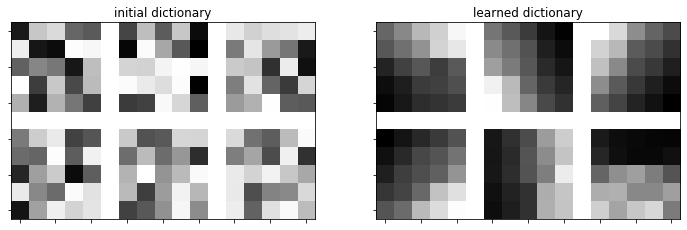

In [4]:
# 学習用データセットで辞書学習
print("### 学習用データセットで畳み込み辞書学習");

print("第１層目:フォワードパスの計算中...");
d0, D0, coef0 = nn_csc(input_ = train_data, d_size = opt['d_size'][0], lmbda = opt['lmbda'][0], Iter = opt['Iter'][0], visualize = True);

"""
print("第１層目:プーリング中...");
coef0 = forward(coef0.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);

print("第２層目:フォワードパスの計算中...");
d1, D1, coef1 = nn_csc(input_ = coef0, d_size = opt['d_size'][1], lmbda = opt['lmbda'][1], Iter = opt['Iter'][1], visualize = False);
print("第２層目:プーリング中...");
coef2 = forward(coef1.squeeze().transpose(2,3,0,1), 2, 2, 2);
# output(opt, D0, coef0, D1, coef1);
"""

<IPython.core.display.Javascript object>


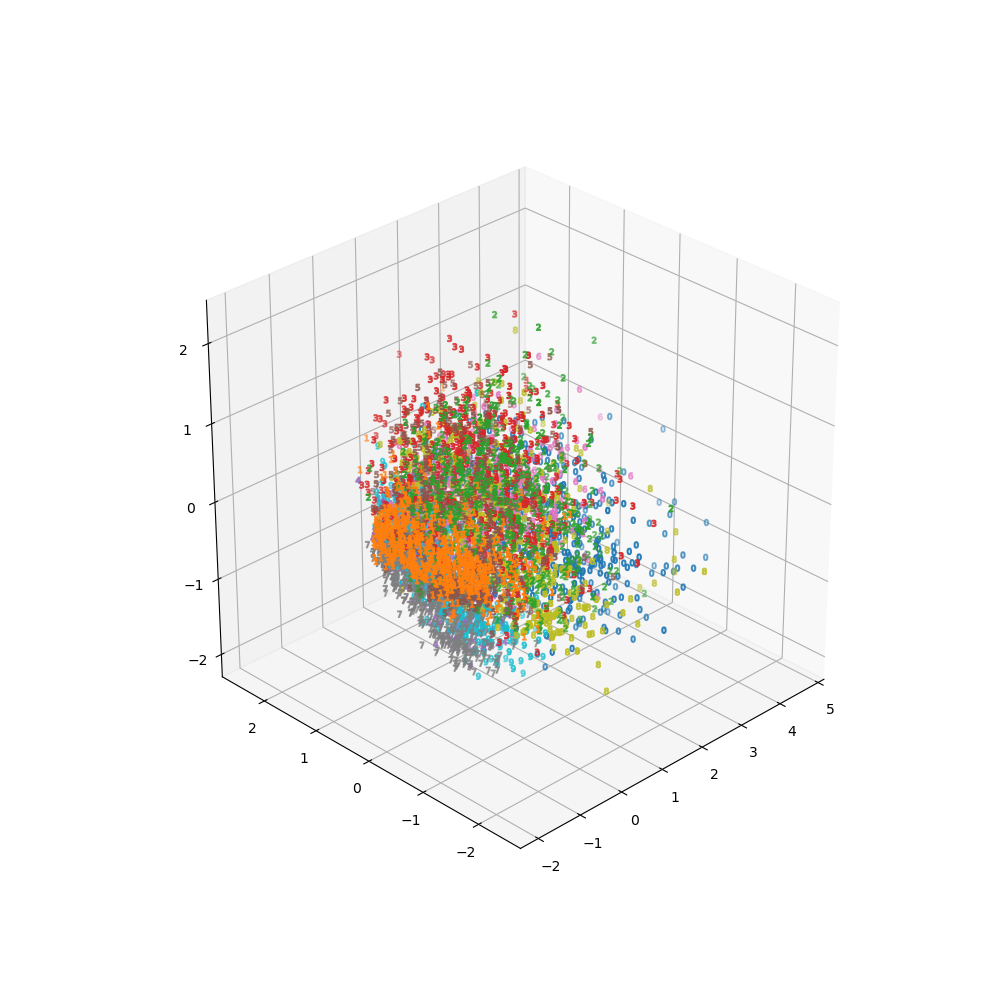

In [7]:
#visualize the 1st layer output (no pooling)
%matplotlib notebook
from visualize import plot_3d
plot_3d(coef0.transpose(3, 0, 1, 2, 4).reshape(opt["train_amount"], -1), train_label)